<a href="https://colab.research.google.com/github/beyzaturku/Weather_Detection_Using_CNN/blob/main/Weather_Detection_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!python --version

Python 3.11.11


In [3]:
!pip install opencv-python

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
zip_path = '/content/drive/MyDrive/Weather_Detection/wd_dataset.zip'

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Google Colab'a dosya yükleme işlemi

In [54]:
from google.colab import files
uploaded = files.upload()

Veri Setini Yükleme

In [6]:
# Assuming 'wd_dataset' is the extracted folder name inside your Google Drive
image_folder = '/content/drive/MyDrive/Weather_Detection/Multi_Class_Weather_Dataset'


subfolders = [ 'Cloudy', 'Rain', 'Shine', 'Sunrise']
label_map = { subfolder: idx for idx, subfolder in enumerate(subfolders)}

# List of Images and Labels
images = []
labels = []

# Loading Dataset
for subfolder in subfolders:
    subfolder_path = os.path.join(image_folder, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (224,224))
            images.append(img_resized)
            labels.append(label_map[subfolder])

# Coverted to Numpy Arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the Images
images = images.astype('float32') / 255.0

Dosya path'lerini kategorilendirme

In [7]:
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes = len(subfolders))

#labels dizisi, her görüntünün sınıfını belirten sayısal etiketleri içerir.
#labels dizininde bulunan kategori etiketlerini one-hot encoding formatına dönüştürür.

Veri Setini Bölme

In [38]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalizasyon
    rotation_range=20,      # 20 dereceye kadar rastgele döndürme
    width_shift_range=0.2,  # Genişlik kaydırma
    height_shift_range=0.2, # Yükseklik kaydırma
    shear_range=0.2,        # Kesme dönüşümü
    zoom_range=0.2,         # Yakınlaştırma
    horizontal_flip=True,   # Yatay çevirme
    validation_split=0.2    # %20 validation için ayırma
)

In [42]:
img_size = (224, 224)
batch_size = 50

train_generator = train_datagen.flow_from_directory(
    image_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    image_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [43]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size = 0.2, stratify = labels_one_hot, random_state = 42)

In [44]:
print("Training data shape:", X_train.shape, "Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape, "Test labels shape:", y_test.shape)

Training data shape: (898, 224, 224, 3) Training labels shape: (898, 4)
Test data shape: (225, 224, 224, 3) Test labels shape: (225, 4)


Model Mimarisi Kurma

In [52]:
model = Sequential([
    # 1. Convolutional Block
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)), # Changed input_shape to (224, 224, 3)
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # 2. Convolutional Block
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # 3. Convolutional Block
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # 4. Convolutional Block
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Overfitting'i önlemek için dropout
    Dense(4, activation='softmax')  # 4 sınıf olduğu için softmax
])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,083,012 (99.50 MB)

 Trainable params: 26,082,052 (99.50 MB)

 Non-trainable params: 960 (3.75 KB)

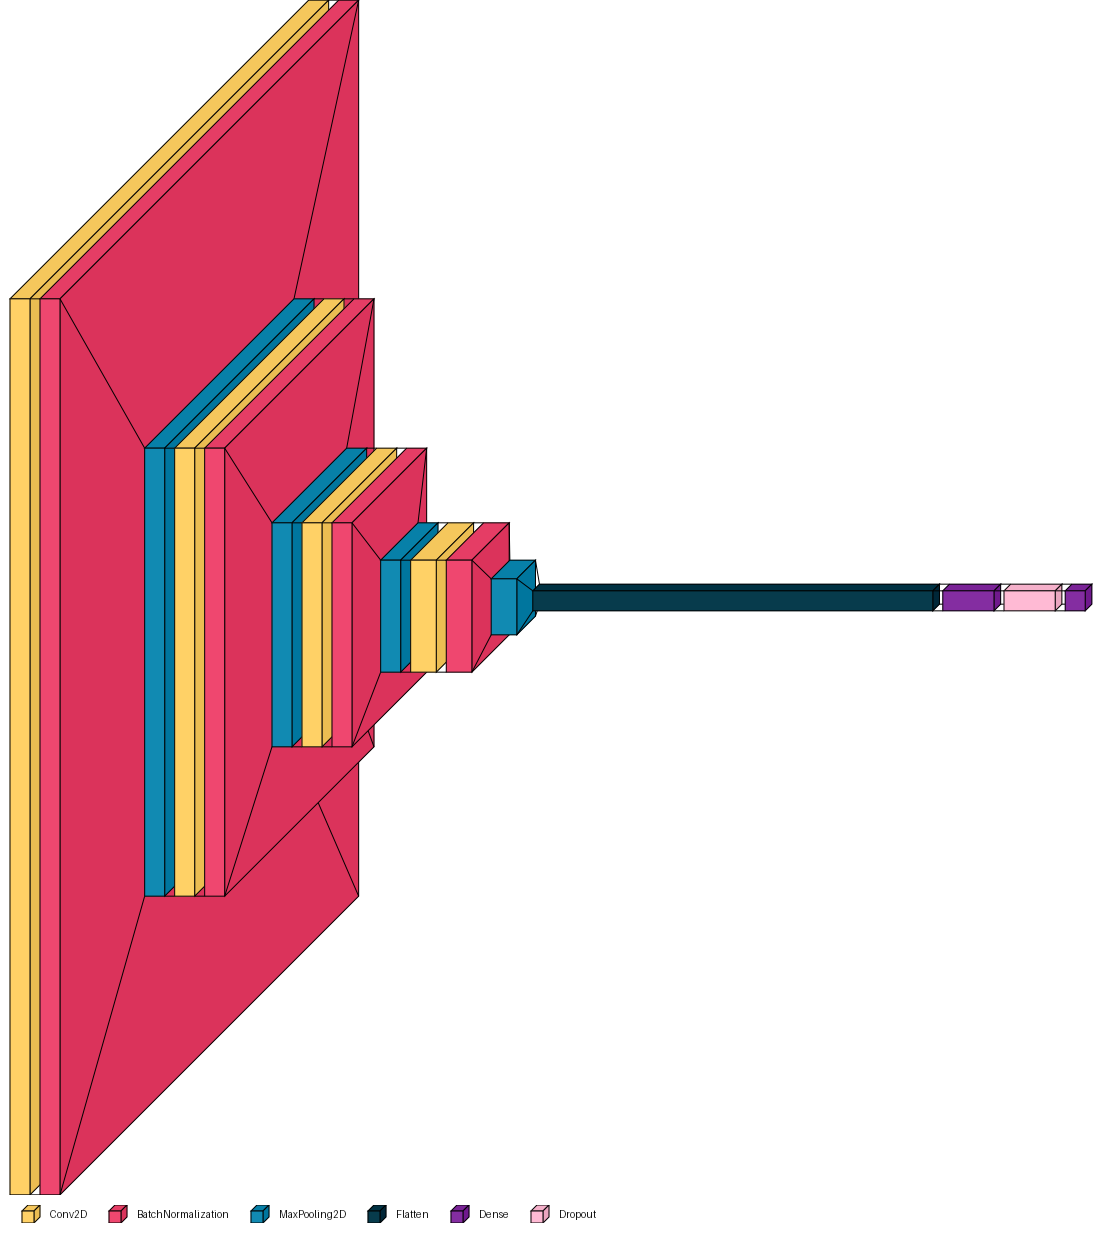

In [53]:
!pip install visualkeras

import visualkeras

visualkeras.layered_view(model, legend=True)

In [54]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Adaptive Learning Rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [55]:
#history = model.fit(X_train, y_train, epochs=20, verbose=2, batch_size=50, validation_data=(X_test, y_test));

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6593 - loss: 2.2968 - val_accuracy: 0.4643 - val_loss: 1.1581
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 656ms/step - accuracy: 0.8726 - loss: 0.7927 - val_accuracy: 0.2679 - val_loss: 2.5508
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 666ms/step - accuracy: 0.8657 - loss: 0.9643 - val_accuracy: 0.3795 - val_loss: 2.0893
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 646ms/step - accuracy: 0.9063 - loss: 0.6396 - val_accuracy: 0.3482 - val_loss: 3.3210
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 695ms/step - accuracy: 0.9150 - loss: 0.4925 - val_accuracy: 0.3036 - val_loss: 4.4718
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 675ms/step - accuracy: 0.8880 - loss: 0.5097 - val_accuracy: 0.2723 - val_loss: 5.5721
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 658ms/step - accuracy: 0.9166 - loss: 0.4936 - val_accuracy: 0.4866 - val_loss: 4.2011
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 664ms/step - accuracy: 0.9180 - loss: 0.3954 - val_accurac

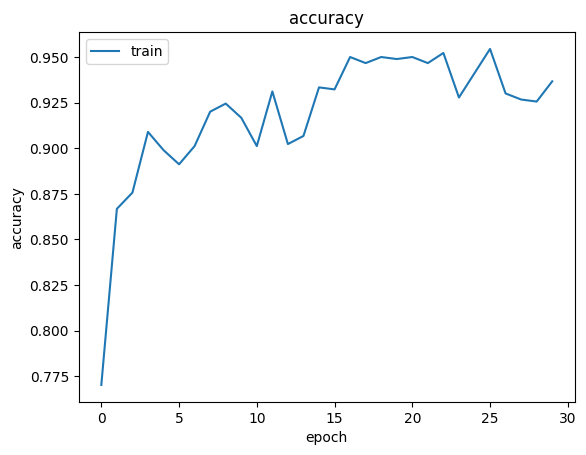

In [56]:
# Accuracy graph
plt.plot(history.history['accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Accuracy')
plt.show()

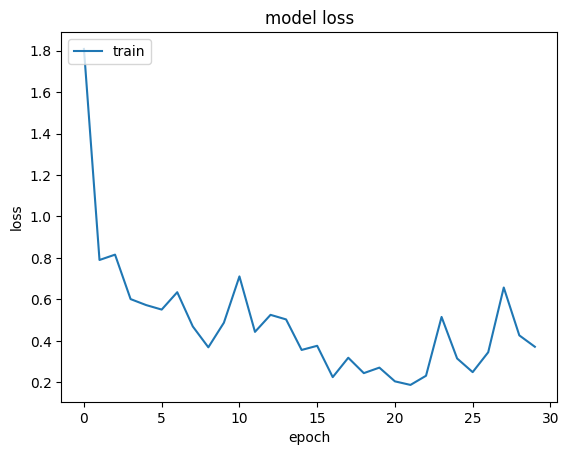

In [57]:
import matplotlib.pyplot as plt

# Loss graph
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Loss')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step


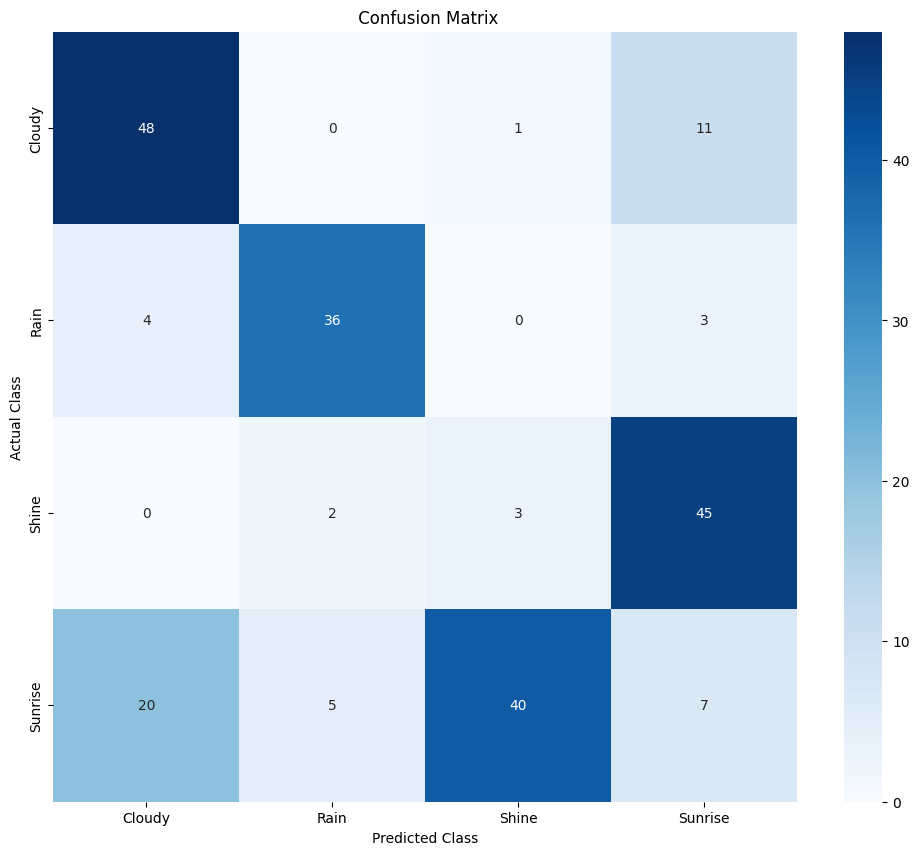

In [59]:
# Confusion Matrix
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12,10))
sns.heatmap(conf_mat , annot =True, fmt = 'd', cmap = 'Blues', xticklabels = subfolders, yticklabels = subfolders)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


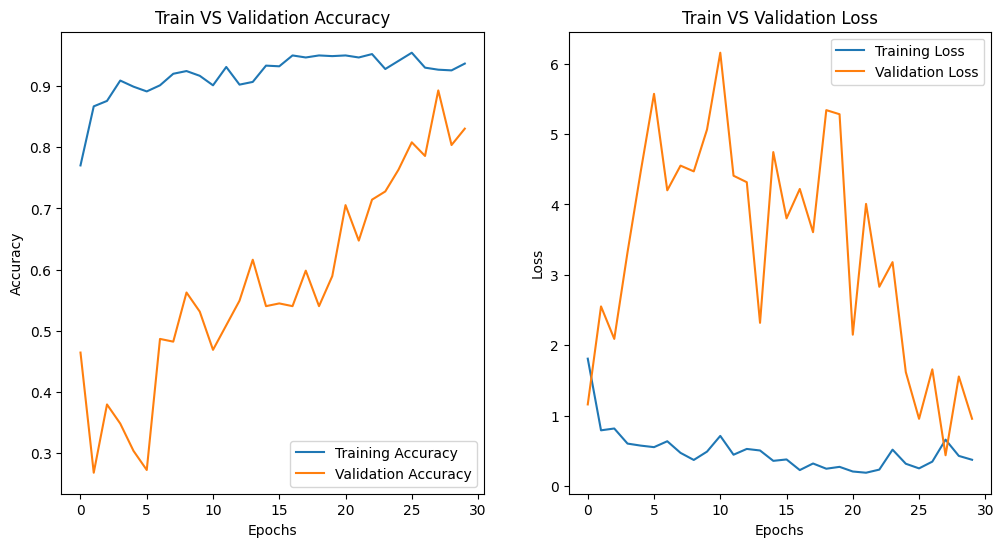

In [60]:
# Plotting for Training and Validation Results

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Train VS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Train VS Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
